In [21]:
import os, sys
cwd = os.getcwd()
print(cwd)

/Users/i522408/Desktop/jupyter-Code


In [22]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

In [23]:

# File paths
TRAIN_TXT = 'TrainingData-set.txt'
TEST_TXT = 'TestingData-set .txt'
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
#word2vec = KeyedVectors.load_word2vec_format(datapath("GoogleNews-vectors-negative300.bin"), binary=True)

In [129]:
X1train = []
X2train = []
Ytrain  = []
X1test = [] 
X2test = []
Ytest = []
test_txt = open("TestingData-set.txt", "r+")
train_txt = open("TrainingData-set.txt", "r+")

print(type(train_txt))


## import the training data and get the two x columns and output column
for line in train_txt:
    #print('\n',"Line  :    ",line)
    if "1" in line:
        Ytrain.append("1")
    elif "0" in line:
        Ytrain.append("0")
    line = line.split(".")
    #print("line ",line)
    X1train.append(line[0])
    str = line[1]
    str = str[1:]
    str = str.replace('1', '')
    str = str.replace('0', '')
    X2train.append(str)
while("" in X2train ) : 
    X2train.remove("")
    
#import the testing data 
for line in test_txt:
    #print('\n',"Line  :    ",line)
    if "1" in line:
        Ytest.append("1")
    elif "0" in line:
        Ytest.append("0")
    line = line.split(".")
    #print('\n',"Line  :    ",line)
    X1test.append(line[0])
    str = line[1]
    str = str[1:]
    str = str.replace('1', '')
    str = str.replace('0', '')
    X2test.append(str)
while("" in X2train ) : 
    X2test.remove("")



 
  
# data frame for training    
d1 = {'question1': X1train, 'question2': X2train, 'is_duplicate': Ytrain}  
train_df = pd.DataFrame(d1) 
    
# data frame for testing
d2 = {'question1': X1test, 'question2': X2test, 'is_duplicate': Ytest}  
test_df = pd.DataFrame(d2) 
test_df  
  

    


<class '_io.TextIOWrapper'>

 Line  :     A person on a horse jumps over a broken down airplane.	A person is at a diner, ordering an omelette.	0


 Line  :     A person on a horse jumps over a broken down airplane.	A person is outdoors, on a horse.	1


 Line  :     Children smiling and waving at camera.	There are children present	1


 Line  :     Children smiling and waving at camera.	The kids are frowning	0


 Line  :     A boy is jumping on skateboard in the middle of a red bridge.	The boy skates down the sidewalk.	0


 Line  :     A boy is jumping on skateboard in the middle of a red bridge.	The boy does a skateboarding trick.	1


 Line  :     An older man sits with his orange juice at a small table in a coffee shop while employees in bright colored shirts smile in the background.	A boy flips a burger.	0


 Line  :     Two blond women are hugging one another.	The women are sleeping.	0


 Line  :     Two blond women are hugging one another.	There are women showing affection.	1


 Lin


 Line  :     Young lady dressed in black shorts and light blue shirt sitting outside at a public table looking at a picture on her camera with her left hand on her face.	A lady looks at her phone.	0


 Line  :     Young lady dressed in black shorts and light blue shirt sitting outside at a public table looking at a picture on her camera with her left hand on her face.	Lady sits gazing at a camera.	1


 Line  :     Young lady dressed in black shorts and light blue shirt sitting outside at a public table looking at a picture on her camera with her left hand on her face.	Young lady sits in a private area.	0


 Line  :     Young lady dressed in black shorts and light blue shirt sitting outside at a public table looking at a picture on her camera with her left hand on her face.	A young lady is looking at her camera.	1


 Line  :     Young lady dressed in black shorts and light blue shirt sitting outside at a public table looking at a picture on her camera with her left hand on her face.	A 

 Line  :     A man and woman watching two kids while the man holds a balloon.	The man is holding a balloon.	1


 Line  :     A group of people sitting at some sort of gathering.	people are together	1


 Line  :     A group of people sitting at some sort of gathering.	the woman sat at the table alone	0


 Line  :     A couple pose in front of a fountain.	There are two people in this picture	1


 Line  :     A couple pose in front of a fountain.	They are waiting to be picked up by aliens	0


 Line  :     Two women standing under an umbrella.	two humans close together	1


 Line  :     Two women standing under an umbrella.	two guys walking in the rain	0


 Line  :     a brown dog is jumping up at a woman who is wearing a brown skirt.	A dog is being friendly.	1


 Line  :     a brown dog is jumping up at a woman who is wearing a brown skirt.	A dog attacks a man.	0


 Line  :     One dog is jumping at the lady while the other walks away.	Two dogs are sleeping next to the lady.	0


 Line  :  

 Line  :     A man on a small bicycle performing a trick on a wall covered with graffiti.	A man is riding a bicycle down a country road.	0


 Line  :     A baseball player hitting a ball.	someone hitting a ball	1


 Line  :     A baseball player hitting a ball.	2 basketball players	0


 Line  :     A trials biker doing a stunt on a graffiti-filled wall.	The person is on a bicycle.	1


 Line  :     A trials biker doing a stunt on a graffiti-filled wall.	The man is on a boat.	0


 Line  :     A bmx rider does a trick against a graffiti covered wall.	A bike rider is outside doing tricks.	1


 Line  :     A bmx rider does a trick against a graffiti covered wall.	The bike rider is sitting on a chair.	0


 Line  :     Two men, both wearing green cycling clothes and helmets, are riding bicycles.	Two guys ride bikes.	1


 Line  :     Two men, both wearing green cycling clothes and helmets, are riding bicycles.	Two guys eat hamburgers in front of TV.	0


 Line  :     A lady in a purple shirt is

IndexError: list index out of range

In [25]:
import nltk
nltk.download('stopwords')
  


## filter out useless words 
stops = set(stopwords.words('english'))





def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    #text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/i522408/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
#dictionary which has X1train, X2train:
#dic = dict(zip(X1train, X2train))
#for (x,y) in dic.items():
 #   print("  X   :  "     +   x   +   "   Y  :  "  + y)
    
    


In [27]:
# Prepare embedding
vocabulary = dict()
train2Dig1 = []
# '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
inverse_vocabulary = ['<unk>']
#vectors can also be instantiated from an existing file on disk in the original Google’s 
# Iterate over the questions only of both training and test datasets
#docToVec

questions_cols = ['question1', 'question2']

# Iterate over the questions only of both training and test datasets
for dataset in [train_df, test_df]:
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions of the row
        for question in questions_cols:

            q2n = []  # q2n -> question numbers representation
            for word in text_to_word_list(row[question]):

                # Check for unwanted words
                if word in stops and word not in word2vec.vocab:
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            dataset.set_value(index, question, q2n)
            
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

del word2vec



/Users/i522408/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [67]:
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max(),
                     test_df.question1.map(lambda x: len(x)).max(),
                     test_df.question2.map(lambda x: len(x)).max())

# Split to train validation
validation_size = 70
training_size = len(train_df) - validation_size

#get data for training 
X = train_df[questions_cols]
Y = train_df['is_duplicate']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)


#get data for testing 
YY = test_df['is_duplicate']

# Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}
X_test = {'left': test_df.question1, 'right': test_df.question2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values
Y_test = YY.values 



# Zero padding
for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)
    
# Zero padding for testing 
for dataset, side in itertools.product([X_test], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)    
    

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)




[[   0    0    0 ...   15   78  744]
 [   0    0    0 ...   78  395  781]
 [   0    0    0 ...   17  213  250]
 ...
 [   0    0    0 ...   83 1127  762]
 [   0    0    0 ... 1132  114 1133]
 [   0    0    0 ...    4 1129 1128]]


In [115]:
#Build a model 
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 25

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))
#make the testing 
predictions = malstm.predict([X_test['left'],X_test['right']],verbose=0,batch_size = 10)
pred = np.around(predictions)
print("prediction output : ",pred)
Y_test = [int(i) for i in Ytest]
Y__test = np.array(Y_test)
print("Actual output : ",Y__test)
print("length type : ",len(Y__test))
print(len(predictions))
print(len(pred))
#test_los , test_acc = malstm.evaluate(Y__test,pred)
#print('Accuracy:', round(test_acc * 100, 2), '%.')



    
#dic = dict(zip(X1test, predictions))
#for (x,y) in dic.items():
 #   print("  X   :  "     +   x   +   "   Y  :  "  + y)

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))



/Users/i522408/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 202 samples, validate on 70 samples
Epoch 1/25
202/202 [==============================] - 1s 7ms/step - loss: 0.4167 - accuracy: 0.4802 - val_loss: 0.3315 - val_accuracy: 0.5857
Epoch 2/25
202/202 [==============================] - 0s 2ms/step - loss: 0.3967 - accuracy: 0.4851 - val_loss: 0.3265 - val_accuracy: 0.6000
Epoch 3/25
202/202 [==============================] - 0s 2ms/step - loss: 0.3792 - accuracy: 0.4851 - val_loss: 0.3215 - val_accuracy: 0.6000
Epoch 4/25
202/202 [==============================] - 0s 2ms/step - loss: 0.3603 - accuracy: 0.4950 - val_loss: 0.3166 - val_accuracy: 0.6000
Epoch 5/25
202/202 [==============================] - 0s 2ms/step - loss: 0.3408 - accuracy: 0.5050 - val_loss: 0.3118 - val_accuracy: 0.6000
Epoch 6/25
202/202 [==============================] - 0s 2ms/step - loss: 0.3214 - accuracy: 0.5198 - val_loss: 0.3077 - val_accuracy: 0.6000
Epoch 7/25
202/202 [==============================] - 0s 2ms/step - loss: 0.3019 - accuracy: 0.5347 - v

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       ...

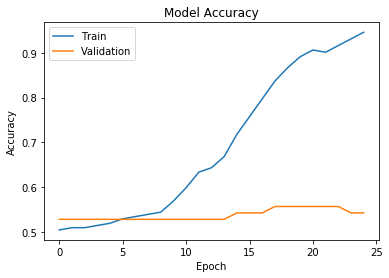

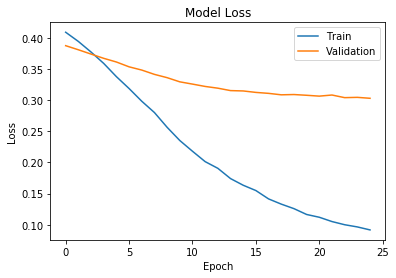

In [35]:
# Plot accuracy
plt.plot(malstm_trained.history['accuracy'])
plt.plot(malstm_trained.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


                     
                     